**Ensemble Model**

1. Seasonal Naive + LightBGM

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8-darkgrid")

In [3]:
train_df = pd.read_csv("../results/Delhi_Hourly_train.csv", parse_dates=['ds'])
test_df = pd.read_csv("../results/Delhi_Hourly_test.csv", parse_dates=['ds'])
train_df

,ds,y,temp,dwpt,rhum,wdir,wspd,pres,hour,weekday,month,is_weekend,hour_sin,hour_cos,lag_1,lag_24,lag_168,rolling_mean_3,rolling_mean_24
0,2021-01-08 00:00:00,4697.857500,13.0,11.60,91.0,145.0,2.7,1014.85,0,4,1,0,0.000000,1.000000,6723.608333,6557.406667,1975.541667,6566.744722,5909.383785
1,2021-01-08 01:00:00,4430.386667,13.0,12.10,94.0,0.0,0.0,1014.00,1,4,1,0,0.258819,0.965926,4697.857500,6331.355833,1805.590000,6048.358056,5831.902569
2,2021-01-08 02:00:00,4238.806667,12.6,12.15,97.0,0.0,0.0,1014.40,2,4,1,0,0.500000,0.866025,4430.386667,6075.757500,1665.914167,5283.950833,5752.695521
3,2021-01-08 03:00:00,4055.965833,12.1,12.10,100.0,0.0,0.0,1013.90,3,4,1,0,0.707107,0.707107,4238.806667,5798.060000,1607.331667,4455.683611,5676.155903
4,2021-01-08 04:00:00,3894.686667,12.0,12.00,100.0,0.0,0.0,1013.00,4,4,1,0,0.866025,0.500000,4055.965833,5545.454167,1676.528333,4241.719722,5603.568646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27528,2024-02-29 00:00:00,2081.147500,18.0,10.35,61.0,290.0,7.6,1015.40,0,3,2,0,0.000000,1.000000,2720.321667,2053.207500,2091.685833,2785.581944,3036.565938
27529,2024-02-29 01:00:00,1917.576667,17.5,10.00,61.5,280.0,6.5,1014.50,1,3,2,0,0.258819,0.965926,2081.147500,1885.863333,1930.974167,2507.263611,3037.730104
27530,2024-02-29 02:00:00,1826.179167,16.0,10.45,70.0,255.0,6.2,1014.00,2,3,2,0,0.500000,0.866025,1917.576667,1814.252500,1843.295833,2239.681944,3039.051493
27531,2024-02-29 03:00:00,1791.240833,14.5,11.00,79.5,250.0,7.3,1014.00,3,3,2,0,0.707107,0.707107,1826.179167,1781.202500,1817.735833,1941.634444,3039.548438


In [4]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

Seasonal Naive

In [5]:
train_df["seasonal_naive"] = train_df["lag_24"]
test_df["seasonal_naive"] = test_df["lag_24"]

In [6]:
sn_mae, sn_rmse = evaluate(test_df["y"], test_df["seasonal_naive"])
print(f"Seasonal Naive -> MAE : {sn_mae:.2f} and RMSE : {sn_rmse:.2f}")

Seasonal Naive -> MAE : 560.21 and RMSE : 876.42



## **Compute Residuals**

### Residual = Actual - Seasonal Naive

Represens:
1. Weather Effects
2. Irregular Effects
3. Deviations from routine behavior

In [7]:
# Create Residual Target
train_df["residual"] = train_df["y"] - train_df["seasonal_naive"]
test_df["residual"] = test_df["y"] - test_df["seasonal_naive"]

In [8]:
# lag_24 already used by seasonal naive.
features = [
    "temp", "dwpt", "rhum", "wdir", "wspd", "pres",
    "hour", "weekday", "month", "is_weekend",
    "hour_sin", "hour_cos",
    "lag_1", "lag_168",
    "rolling_mean_3", "rolling_mean_24"
]

In [9]:
lgbm_residual = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_residual.fit(
    train_df[features],
    train_df["residual"]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2499
[LightGBM] [Info] Number of data points in the train set: 27533, number of used features: 16
[LightGBM] [Info] Start training from score -2.500792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Final Prediction = Seasonal Naive + Predicted Residual

In [10]:
test_residual_pred = lgbm_residual.predict(test_df[features])
ensemble_pred = test_df["seasonal_naive"] + test_residual_pred

In [11]:
ens_mae, ens_rmse = evaluate(test_df["y"], ensemble_pred)
print(f"ENSEMBLE → MAE: {ens_mae:.2f}, RMSE: {ens_rmse:.2f}")

ENSEMBLE → MAE: 367.93, RMSE: 559.22


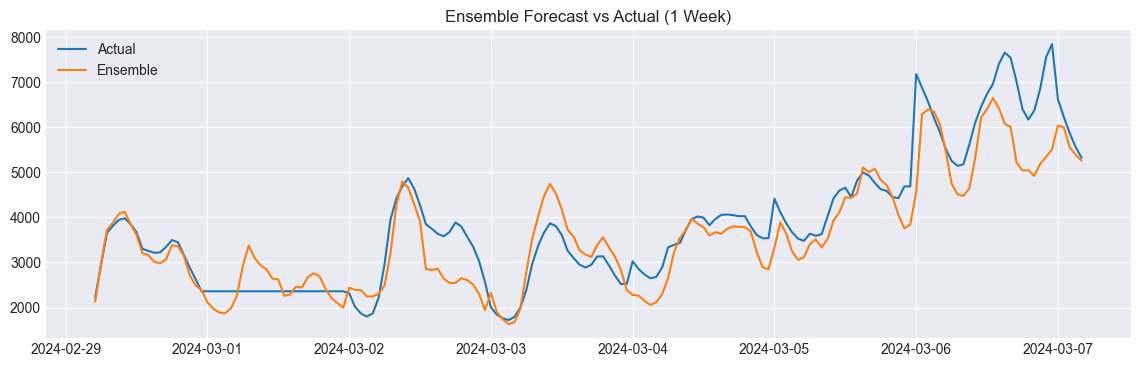

In [12]:
plt.figure(figsize=(14,4))

plt.plot(test_df.ds[:168], test_df.y.values[:168], label="Actual")
plt.plot(test_df.ds[:168], ensemble_pred[:168], label="Ensemble")

plt.title("Ensemble Forecast vs Actual (1 Week)")
plt.legend()
plt.show()

In [13]:
results = pd.DataFrame({
    "Model": [
        "Seasonal Naive",
        "Prophet",
        "LightGBM",
        "Ensemble (SN + LGBM)"
    ],
    "MAE": [
        560.21,
        2527.92,
        127.53,
        ens_mae
    ],
    "RMSE": [
        876.42,
        2870.06,
        274.60,
        ens_rmse
    ]
})

results

,Model,MAE,RMSE
0,Seasonal Naive,560.210000,876.420000
1,Prophet,2527.920000,2870.060000
2,LightGBM,127.530000,274.600000
3,Ensemble (SN + LGBM),367.929841,559.220895


**Although residual-based ensembling is often effective, in this case a single well-tuned LightGBM model outperformed the ensemble, indicating that gradient boosting alone was sufficient to capture both seasonal structure and short-term deviations.**